<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/280a_custom_object_segmentation_using_stardist_TRAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/3yk9sBja7YI

Training custom models for segmentation using StarDist 

In [ ]:
!pip install stardist

In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [ ]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [ ]:
#Read input image and corresponding mask names
X = sorted(glob('/content/drive/MyDrive/Colab Notebooks/data/mito_dataset_256x256/mito_images/*.tif'))
Y = sorted(glob('/content/drive/MyDrive/Colab Notebooks/data/mito_dataset_256x256/mito_masks/*.tif'))


In [ ]:
#Read images and masks using their names.
#We are using tifffile library to read images as we have tif images. 
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.

In [ ]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 160/160 [00:00<00:00, 698.61it/s]


In [ ]:
#Split to train and val
#You can use any method to split. I am following the method used in StarDist documentation example
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 160
- training:       136
- validation:      24


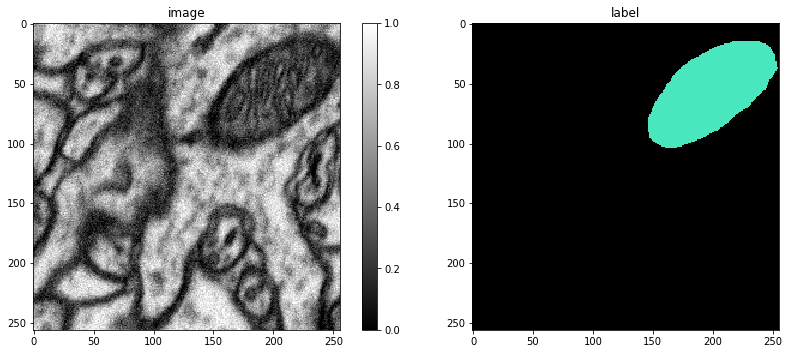

In [ ]:
#PLot image and label for some images - sanity check
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()
    
    
i = min(9, len(X)-1)

img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)


In [ ]:
#Check config to get an idea about all parameters
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [ ]:
#Define the config by setting some parameter values

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', 

{'axes': 'YXC',
 'backbone': 'unet',
 'grid': (2, 2),
 'n_channel_in': 1,
 'n_channel_out': 33,
 'n_classes': None,
 'n_dim': 2,
 'n_rays': 32,
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_background_reg': 0.0001,
 'train_batch_size': 4,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_class_weights': (1, 1),
 'train_completion_crop': 32,
 'train_dist_loss': 'mae',
 'train_epochs': 400,
 'train_foreground_only': 0.9,
 'train_learning_rate': 0.0003,
 'train_loss_weights': (1, 0.2),
 'train_n_val_patches': None,
 'train_patch_size': (256, 256),
 'train_reduce_lr': {'factor': 0.5, 'min_delta': 0, 'patience': 40},
 'train_sample_cache': True,
 'train_shape_completion': False,
 'train_steps_per_epoch': 100,
 'train_tensorboard': True,
 'unet_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_kernel_size': (3, 3),


In [ ]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [ ]:
#Save model to the specified directory
model = StarDist2D(conf, name='stardist_tutorial', basedir='/content/drive/MyDrive/Colab Notebooks/models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [ ]:
#Define the network field of view to size larger than the median object size
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")
    

median object size:      [86. 85.]
network field of view :  [94 94]


In [ ]:
#Define a few augmentation methods
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

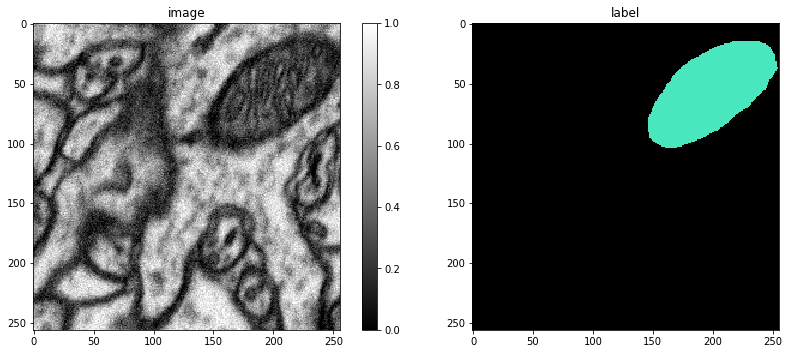

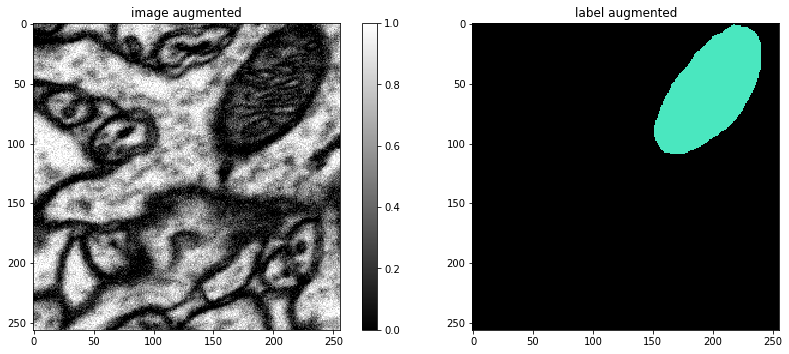

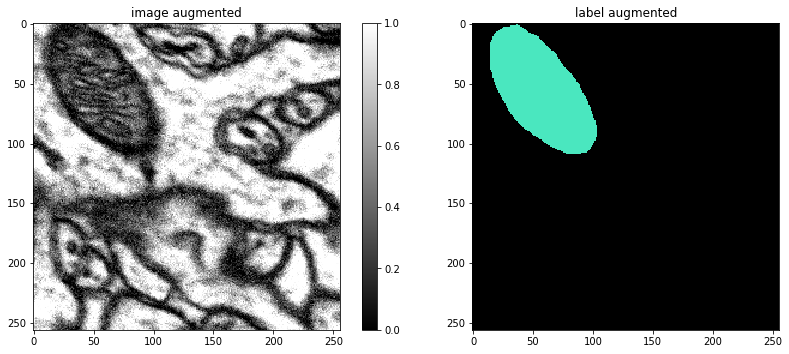

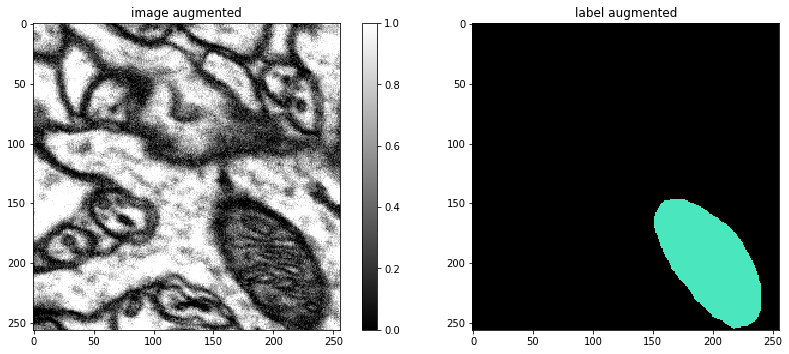

In [ ]:
# plot some augmented examples
img, lbl = X[9],Y[9]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")
    

In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=10, steps_per_epoch=100)

Epoch 1/10
Cause: Unable to locate the source code of <function _gcd_import at 0x7f8affec0b00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x7f8affec0b00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the funct

KeyboardInterrupt: ignored

In [ ]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:01<00:00, 10.87it/s, 0.091 -> 0.000]


Using optimized values: prob_thresh=0.091031, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'nms': 0.3, 'prob': 0.09103104892691956}

In [ ]:
#Load saved model
my_model = StarDist2D(None, name='stardist', basedir='/content/drive/MyDrive/Colab Notebooks/models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.562851, nms_thresh=0.3.


In [ ]:
model=my_model

In [ ]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]


100%|██████████| 24/24 [00:01<00:00, 12.22it/s]


100%|██████████| 9/9 [00:00<00:00, 13.52it/s]


DatasetMatching(criterion='iou', thresh=0.5, fp=6, tp=16, fn=2, precision=0.7272727272727273, recall=0.8888888888888888, accuracy=0.6666666666666666, f1=0.8, n_true=18, n_pred=22, mean_true_score=0.6759215427769555, mean_matched_score=0.7604117356240749, panoptic_quality=0.60832938849926, by_image=False)

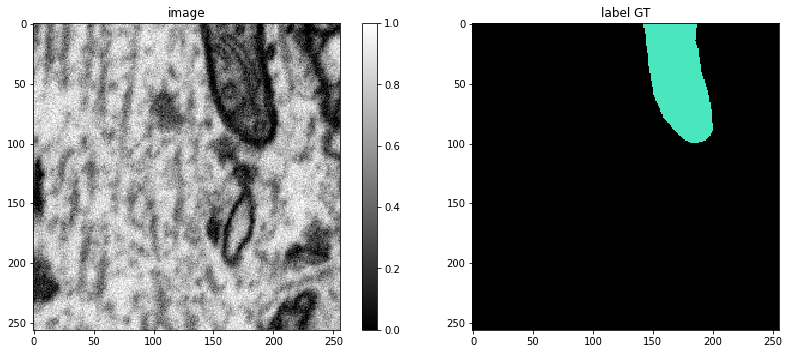

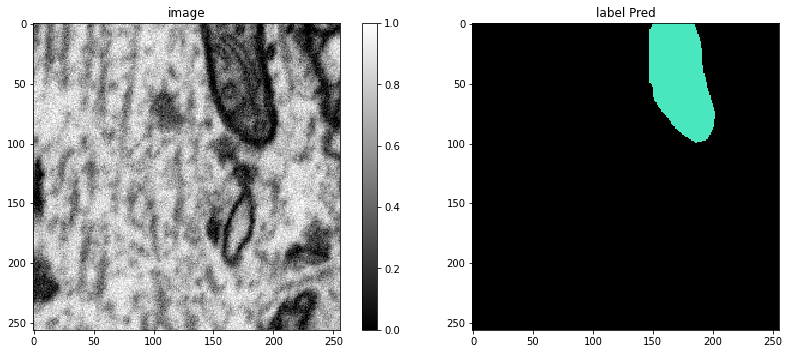

In [ ]:
#PLot original labels and predcitions
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]






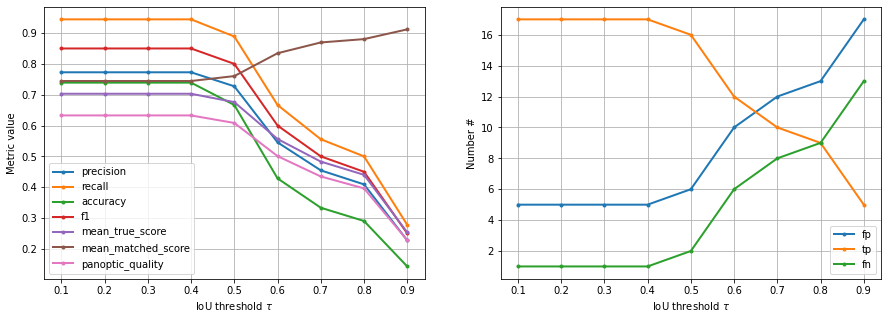

In [ ]:
#Plot key metrics 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

